In [23]:
import pandas as pd
import os
import torch
import clip
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load CLIP

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)

# Load and Embed Corpus Images

In [25]:
corp_2 = pd.read_json('marqo_gs_wfash_1m/corpus_2.json')
corp_1 = pd.read_json('marqo_gs_wfash_1m/corpus_1.json')

corp_2_transposed = corp_2.T
corp_1_transposed = corp_1.T

corp_1_transposed['image_local'] = corp_1_transposed['image_local'].apply(
    lambda x: os.path.join("images_wfash", os.path.basename(x))
)

corp_2_transposed['image_local'] = corp_2_transposed['image_local'].apply(
    lambda x: os.path.join("images_wfash", os.path.basename(x))
)

# image_paths = corp_1_transposed['image_local'].tolist()
# image_embeddings = []
# valid_image_ids = []

# for i, path in enumerate(tqdm(image_paths)):
#     try:
#         image = preprocess(Image.open(path)).unsqueeze(0).to(device)
#         with torch.no_grad():
#             image_embedding = model.encode_image(image)
#         image_embeddings.append(image_embedding)
#         valid_image_ids.append(i)  # Save index
#     except:
#         print(f"Failed to load {path}")

# image_embeddings_tensor = torch.vstack(image_embeddings)

# torch.save({
#     'embeddings': image_embeddings_tensor,
#     'valid_image_ids': valid_image_ids
# }, 'clip_corpus1_embeddings.pt')


# Already ran, takes 9 hours



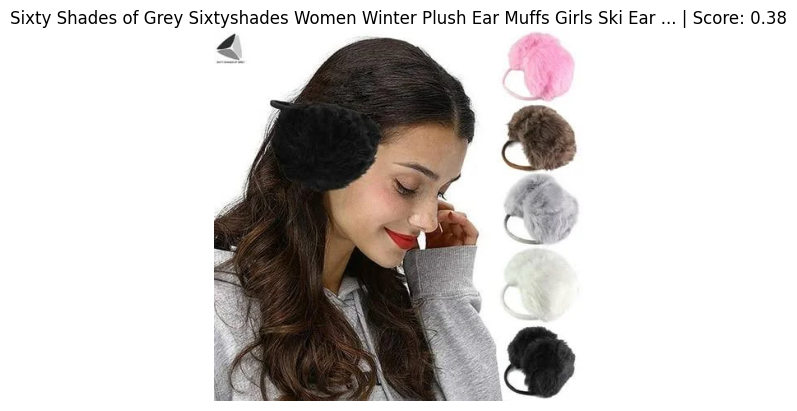

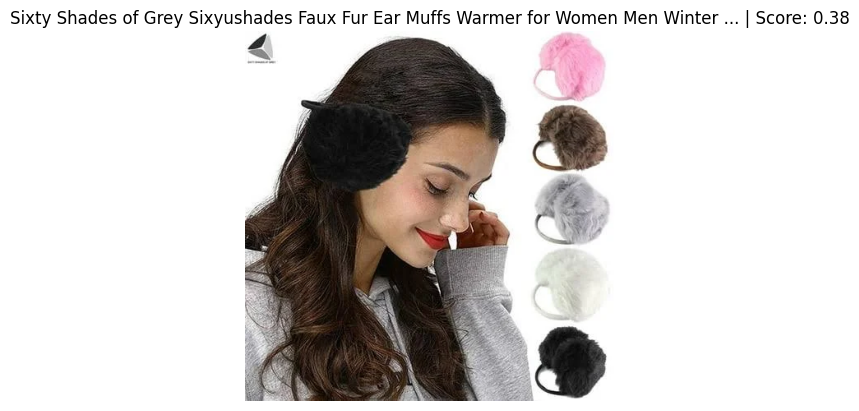

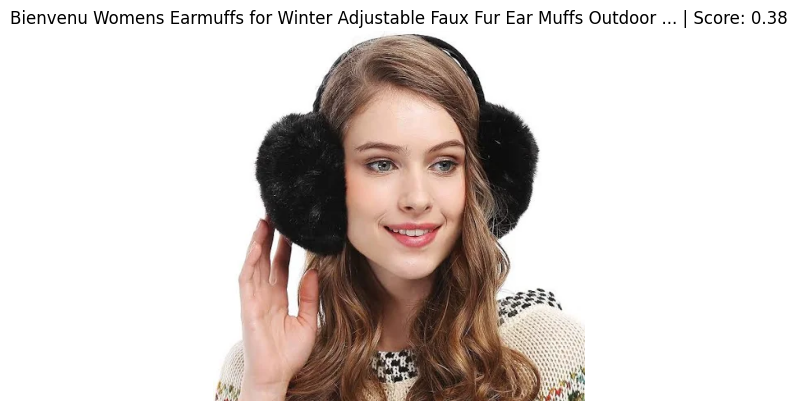

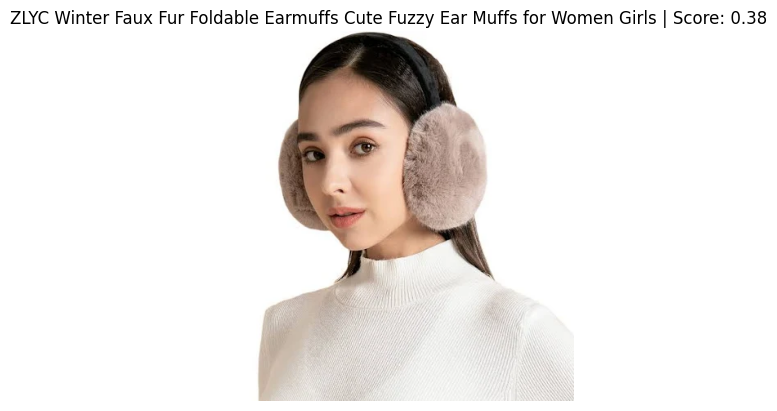

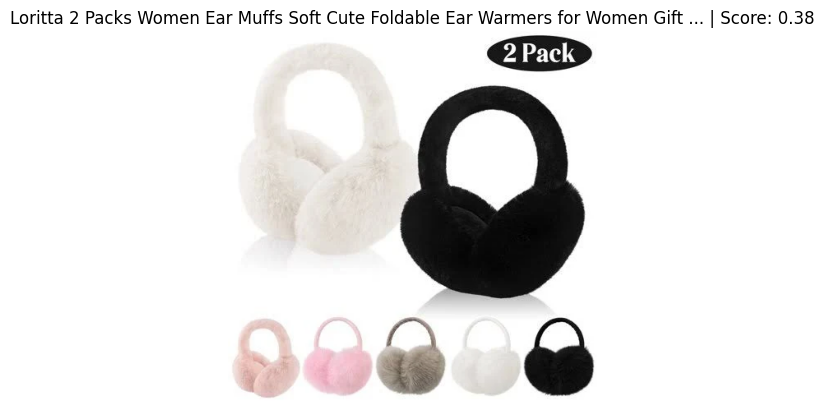

In [26]:
clip_corpus1 = torch.load('clip_corpus1_embeddings.pt', map_location=device)
image_embeddings = clip_corpus1['embeddings']
valid_image_ids = clip_corpus1['valid_image_ids']

query_text = "No-slip earmuffs for women"

text_token = clip.tokenize([query_text]).to(device)

with torch.no_grad():
    text_embedding = model.encode_text(text_token)
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)  # normalize


# Normalize image embeddings
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

# Compute cosine similarity
similarities = (image_embeddings @ text_embedding.T).squeeze(1)

# Get top-5 results
top_k = similarities.topk(5)

for i in top_k.indices:
    idx = valid_image_ids[i]
    row = corp_1_transposed.iloc[idx]
    img = Image.open(row['image_local'])
    
    plt.imshow(img)
    plt.title(f"{row['title']} | Score: {similarities[i].item():.2f}")
    plt.axis('off')
    plt.show()
